In [1]:
# Imported relevant libraries for the assigment
import pystan
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import signal
import matplotlib.pyplot as plt
from datetime import datetime,timedelta

# Data processing

In [2]:
# Imported the Mauna Loa Observatory dataset
data = pd.read_csv('weekly_in_situ_co2_mlo.csv',names=['Date','Concentration'],skiprows=44)

# Set dates as datetime objects and added a column for days since first observation
data['Date'] = pd.to_datetime(data['Date'])
data['Days'] = (data['Date'] - data['Date'][0]).dt.days

# Created a list of dates to predict (with corresponding days since first observation)
max_day = int((pd.to_datetime('2060-01-31') - data['Date'][0]).total_seconds()/60/60/24)
future_days = [int(data['Days'].iloc[-1] + 7*(x+1)) for x in range((max_day - data['Days'].iloc[-1])//7)]
future_dates = [data['Date'][0] + timedelta(days=d) for d in future_days]

In [3]:
# Defined a function to plot CO2 predictions against observed CO2 concentrations
def plotting(posterior=[]):
    fig, axs = plt.subplots(1,2,figsize=(15, 5), gridspec_kw={'width_ratios': [1.75, 1]})

    # Plotted the original observations 
    axs[0].plot(data.Date,data.Concentration,color='b',lw=0.6,label='Observations',alpha=0.8)
    
    # Plotted the last 5 years of observations with its linear trend
    m, b = np. polyfit(data.Days[len(data)-275:],data.Concentration[len(data)-275:], 1)
    axs[1].plot(data.Date[len(data)-275:],data.Concentration[len(data)-275:],
                color='b',lw=0.8,label=f'Observations (m={m:.4f})',alpha=0.8)
    axs[1].plot(data.Date[len(data)-275:], m*data.Days[len(data)-275:] + b,
                color='b',linestyle='dashed',alpha=0.8)
    
    # Evaluated if predictions are provided
    if len(posterior) >= len(data):
        # Plotted the predictions against the observations
        axs[0].plot(data.Date,posterior[:len(data)],color='k',lw=0.6,label='Model')
        
        # Plotted the last 5 years of the predictions with its linear trend
        m2, b2 = np. polyfit(data.Days[len(data)-275:],posterior[len(data)-275:len(data)], 1)
        axs[1].plot(data.Date[len(data)-275:],posterior[len(data)-275:len(data)],
                    color='k',lw=0.8,label=f'Model (m={m2:.4f})')
        axs[1].plot(data.Date[len(data)-275:], m2*data.Days[len(data)-275:] + b2,
                    color='k',linestyle='dashed')
        
        # Printed metrics to evaluate the accuracy of the model
        errors = [(data.Concentration[i]-posterior[i])**2 for i in range(len(data))]
        print(f'MSE = {np.mean(errors)}')
        print(f'RMSE = {np.sqrt(np.mean(errors))}')
    
    # Set labels, titles, and grids for both figures
    axs[0].title.set_text(f'Carbon dioxide concentration over time ({data.Date[0].year}-{data.Date.iloc[-1].year})')
    axs[1].title.set_text('CO2 fluctuations in the last 5 years')
    plt.setp(axs, xlabel='Date')
    plt.setp(axs, ylabel='CO2 concentration [ppm]')
    axs[0].legend(fontsize=12)
    axs[1].legend()
    axs[0].grid()
    axs[1].grid()

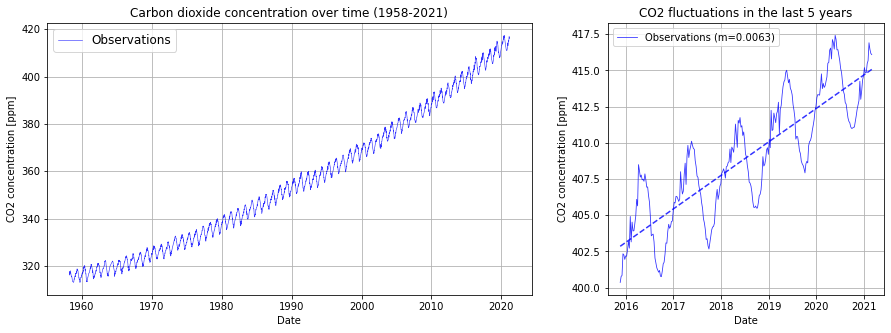

In [4]:
# Ran the plotting function above to show the dataset
plotting()

# Model implementation

In [5]:
# Defined the Stan data for the model
stan_data = {
    'n': len(data),
    'n_future': len(data) + len(future_days),
    'co2': data.Concentration,
    't': list(data['Days'])+future_days}

In [6]:
stan_code = """
data {
    int<lower=0> n;               // measurement count
    int<lower=0> n_future;        // measurement count for projection
    real<lower=0> co2[n];         // CO2 concentration measurement
    real<lower=0> t[n_future];    // days since first measurement
}

parameters {
    real<lower=0> c0;             // intercept
    real<lower=0> c1;             // slope of the linear trend
    real<lower=0> c2;             // quadratic term
    real<lower=0> c3;             // amplitude
    real<lower=0> c4;             // phase shift
    real<lower=0.2> c5;           // standard deviation of the noise
}

model {
    c0 ~ normal(315, 2);                // Priors over the parameters
    c1 ~ normal(1.6/365.25, 0.001);     
    c2 ~ normal(1.6/365.25, 0.001);     
    c3 ~ cauchy(0, 1);                  
    c4 ~ cauchy(0, 1);
    c5 ~ normal(0.2,2);
    
                                        // Likelihood function
    for (i in 1:n) {
        co2[i] ~ normal(c0 + c1 * t[i] + c2 * (t[i])^2 + 
        c3 * cos(((2 * pi() * t[i]) / 365.25) + (c4+log(t[i]+2)/3)), c5);
    }
}

generated quantities{
    real co2_future[n_future];          // Creates predictions for CO2 concentrations
    for(j in 1:n_future){
        co2_future[j] = normal_rng(c0 + c1 * t[j] + c2 * (t[j])^2 + 
        c3 * cos(((2 * pi() * t[j]) / 365.25) + (c4+log(t[j]+2)/3)), c5);    
    }
}
"""

In [7]:
# Compiled the model using the Stan code above
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b55624db68d25035a4ae665c50fb9066 NOW.


In [8]:
# Generated posterior samples from the model and data
stan_results = stan_model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [9]:
# Printed a Stan summary of posterior parameters including 95% CI
parameters = stan_results.model_pars[:-1]
print(stan_results.stansummary(pars=parameters))

Inference for Stan model: anon_model_b55624db68d25035a4ae665c50fb9066.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0 314.76  1.4e-3   0.06 314.65 314.72 314.76  314.8 314.88   2014    1.0
c1 2.0e-3  3.0e-7 1.2e-5 2.0e-3 2.0e-3 2.0e-3 2.1e-3 2.1e-3   1638    1.0
c210.0e-8 1.2e-115.0e-10 9.9e-8 9.9e-810.0e-8 1.0e-7 1.0e-7   1646    1.0
c3   2.76  2.2e-3   0.03   2.71   2.74   2.76   2.78   2.82    180    1.0
c4   2.82  3.1e-4 9.1e-3    2.8   2.82   2.82   2.83   2.84    855    1.0
c5   1.11  2.7e-4   0.01   1.08    1.1   1.11   1.12   1.13   2794    1.0

Samples were drawn using NUTS at Fri Apr  9 02:17:21 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [10]:
# Extracted the samples from the model and calculated relevant statistics for each estimated concentration
samples = stan_results.extract()
means = [np.mean(samples['co2_future'][:,i]) for i in range(len(samples['co2_future'][0]))]
upper_bounds = [np.percentile(samples['co2_future'][:,i],[97.5]) for i in range(len(samples['co2_future'][0]))]
lower_bounds = [np.percentile(samples['co2_future'][:,i],[2.5]) for i in range(len(samples['co2_future'][0]))]

MSE = 1.2233813417932686
RMSE = 1.1060657041031825


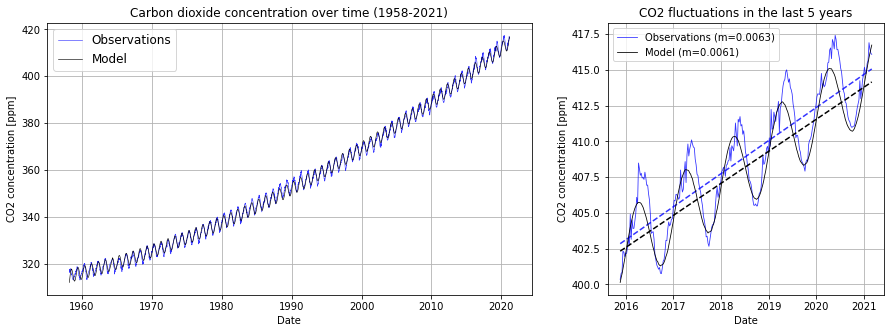

In [11]:
# Plotted the average estimated values against the real data
plotting(means)

# Model analysis

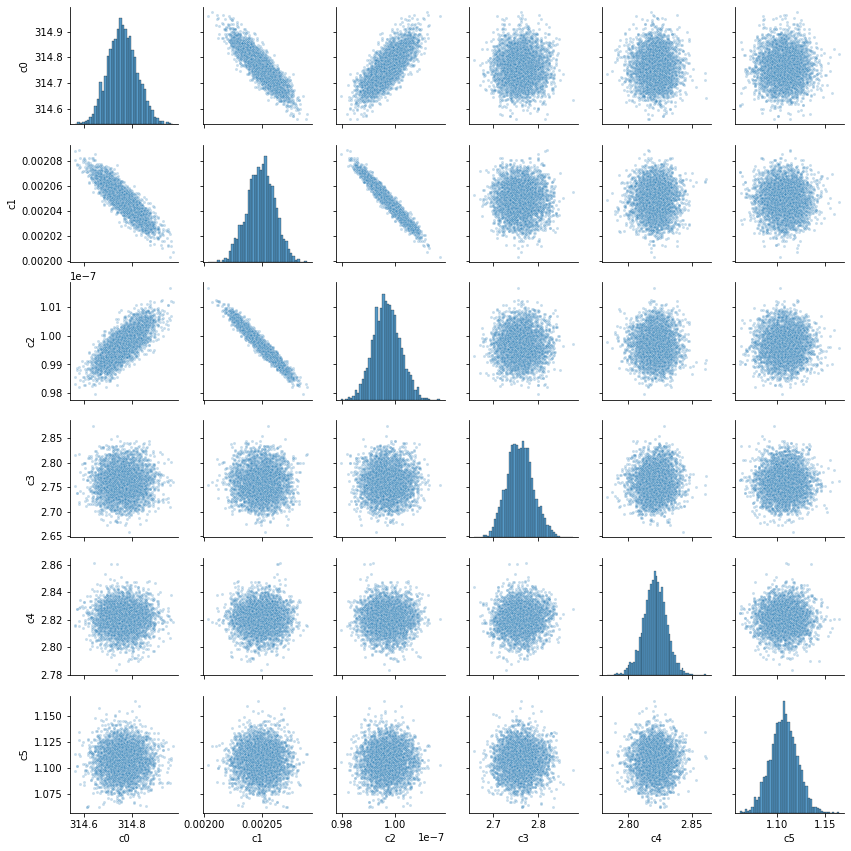

In [12]:
# Created a pair plot for the model's parameters. Code extracted from CS146 Session 14.1
df = pd.DataFrame(data=np.transpose([samples[param] for param in parameters]),columns=parameters)
sn.pairplot(df, height=2, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

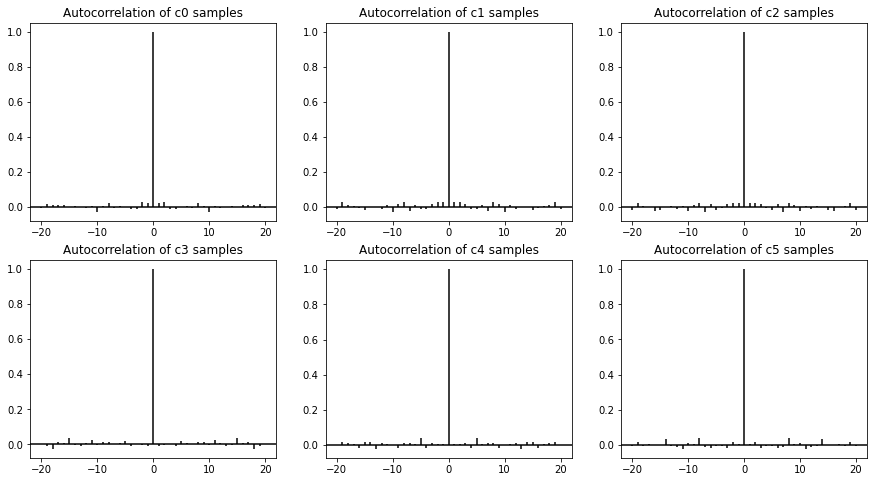

In [13]:
# Defined autocorrelation function. Code extracted from CS146 Session 14.1
def plot_acf(x):        
    plt.acorr(x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'),color='k')

# Plotted the autocorrelation of the parameters
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for i, ax in enumerate(axs.flat):
    plt.subplot(231+i)
    plot_acf(samples[parameters[i]])
    plt.title(f'Autocorrelation of {parameters[i]} samples')
plt.show()

In [14]:
# Defined the Stan data for the prior by removing the observations
stan_prior_data = {
    'n': 0,
    'n_future': len(data) + len(future_days),
    'co2': [],
    't': list(data['Days'])+future_days}

In [15]:
# Generated prior samples from the model and data
stan_prior_results = stan_model.sampling(data=stan_prior_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [16]:
# Printed a Stan summary of prior parameters including 95% CI
print(stan_prior_results.stansummary(pars=parameters))

Inference for Stan model: anon_model_b55624db68d25035a4ae665c50fb9066.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0  315.0    0.03   2.02 310.98 313.65 315.04 316.34 318.89   5184    1.0
c1 4.4e-3  1.5e-5 9.8e-4 2.5e-3 3.7e-3 4.4e-3 5.0e-3 6.3e-3   4232    1.0
c2 4.4e-3  1.8e-5 1.0e-3 2.4e-3 3.7e-3 4.4e-3 5.0e-3 6.3e-3   3170    1.0
c3   4.42    0.58  33.29   0.03   0.43    1.0   2.34  22.53   3348    1.0
c4    6.6    2.62 101.19   0.04   0.41    1.0   2.35  24.45   1493    1.0
c5   1.78    0.02    1.2   0.26   0.82   1.55   2.48   4.67   4121    1.0

Samples were drawn using NUTS at Fri Apr  9 02:17:35 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


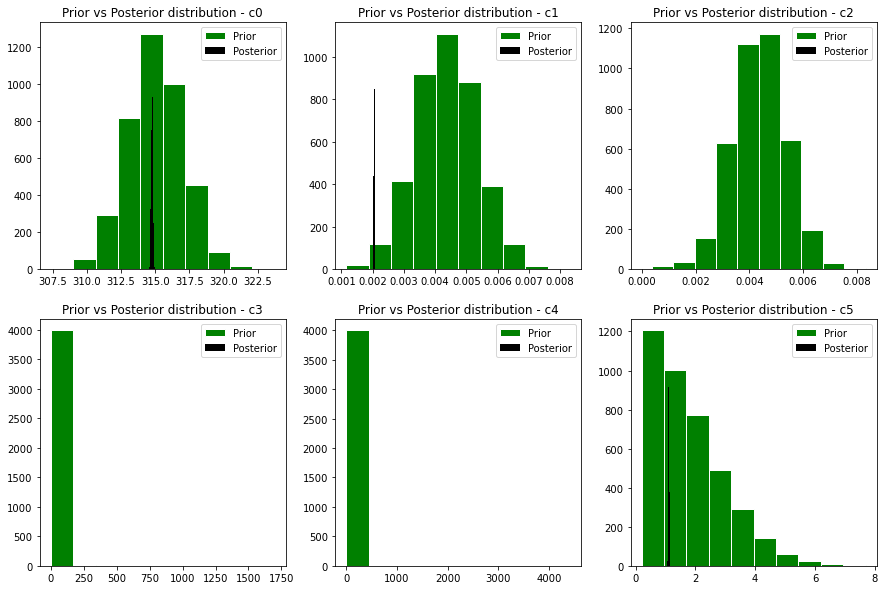

In [17]:
# Extracted the prior samples from the model
prior_samples = stan_prior_results.extract()

# Plotted prior vs posterior sample distributions of each parameter
fig, axs = plt.subplots(2,3,figsize=(15, 10))
for i in range(len(parameters)):
    plt.subplot(2,3,i+1)
    plt.hist(prior_samples[parameters[i]],color='g',label='Prior',edgecolor='w')
    plt.hist(samples[parameters[i]],color='k',label='Posterior')
    plt.title(f'Prior vs Posterior distribution - {parameters[i]}')
    plt.legend()

plt.show()

# CO2 Prediction

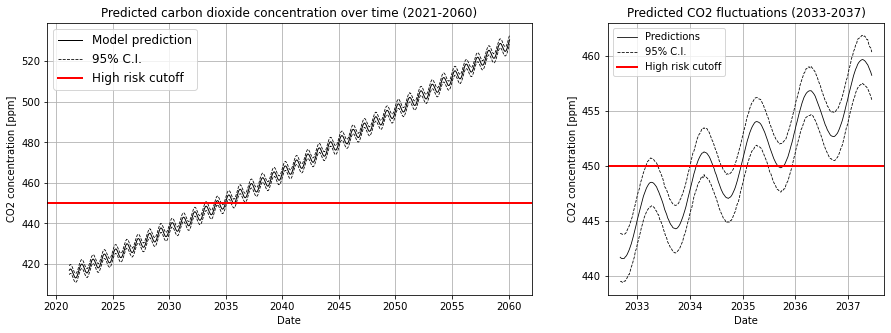

In [18]:
fig, axs = plt.subplots(1,2,figsize=(15, 5), gridspec_kw={'width_ratios': [1.75, 1]})

# Plotted CO2 predicted concentrations until 2060
axs[0].plot(future_dates,means[len(data):],color='k',lw=1,label='Model prediction')
axs[0].plot(future_dates,upper_bounds[len(data):],color='k',lw=0.8,linestyle='dashed',label='95% C.I.')
axs[0].plot(future_dates,lower_bounds[len(data):],color='k',lw=0.8,linestyle='dashed')
axs[0].axhline(450,lw=2,color='r',label='High risk cutoff')
axs[0].legend()
    
# Plotted the region where CO2 concentrations are expected to surpass the high-risk cutoff
axs[1].plot(future_dates[600:850],means[len(data)+600:len(data)+850],color='k',lw=0.8,label=f'Predictions')
axs[1].plot(future_dates[600:850],upper_bounds[len(data)+600:len(data)+850],color='k',lw=0.8,linestyle='dashed',label='95% C.I.')
axs[1].plot(future_dates[600:850],lower_bounds[len(data)+600:len(data)+850],color='k',lw=0.8,linestyle='dashed')
axs[1].axhline(450,lw=2,color='r',label='High risk cutoff')

# Set labels, titles, and grids for both figures
axs[0].title.set_text('Predicted carbon dioxide concentration over time (2021-2060)')
axs[1].title.set_text('Predicted CO2 fluctuations (2033-2037)')
plt.setp(axs, xlabel='Date')
plt.setp(axs, ylabel='CO2 concentration [ppm]')
axs[0].legend(fontsize=12)
axs[1].legend()
axs[0].grid()
axs[1].grid()

plt.show()